# Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data preparation

### 1.1. Read data from file

In [6]:
#load the datasets (train data and test data which are pre-splitted)
data1 = MNIST(root='MNIST_dataset', train=True, download=True)
data2 = MNIST(root='MNIST_dataset', train=False, download=True)

#concatenate the data and labels from train and test datasets
all_images = torch.cat((data1.data, data2.data), dim=0)
all_labels = torch.cat((data1.targets, data2.targets), dim=0)

Now, we have 70,000 images intotal.

In [7]:
x = all_images.numpy()
y = all_labels.numpy()

print("Total images:", x.shape[0])

Total images: 70000


### 1.2. Normalizing the data

In [8]:
x = x / 255.0  # Normalize pixel values to [0, 1] range

print("min pixel value:", x.min(), ", max pixel value:", x.max())

min pixel value: 0.0 , max pixel value: 1.0


### 1.3. Splitting into train, validtaion and test sets

In [9]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size= 0.6, random_state=42, stratify=y) # 60% train, 40% to split again into val and test
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42, stratify=y_rest) # 40% * 50% = 20% val, 20% test

print("Training set = ", x_train.shape[0])
print("Validation set = ", x_val.shape[0])
print("Test set = ", x_test.shape[0])

Training set =  42000
Validation set =  14000
Test set =  14000


### 1.4. Pytorch DataLoaders

In [10]:
# change from numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_val_tensor = torch.from_numpy(x_val).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).long()

x_test_tensor = torch.from_numpy(x_test).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders with batch size = 64 to optimize training
train_NN_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_NN_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_NN_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Neural Network model
### 2.1. Feed Forward NN

In [11]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, number_hidden_layers, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size)) 
        for i in range(number_hidden_layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size)) 
        self.layers.append(nn.Linear(hidden_size, output_size)) 

        self.weight_initialization()

    def weight_initialization(self):
        # He initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity= 'relu')
                
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
   
    def forward(self, x):
        
        x = x.view(x.size(0), -1) # flatten input (28x28 to 784)
        
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)

        return x

### 2.2. Training the NN model

In [43]:
def training_infrastructure (NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for gpu acceleration
    print(f"Using {device}") #check if gpu acceleration is working

    INPUT_SIZE = 784
    OUTPUT_SIZE = 10 

    training_losses = []
    training_accurices = []
    validation_losses = []
    validation_accurices = []

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = FeedForwardNN(INPUT_SIZE, NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss()

    num_total_steps = len(train_loader)
    for epoch in range(NUM_EPOCHS):

        # training loop
        model.train()
        current_train_loss = 0
        total = 0
        correct = 0

        for i, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)

            #forward
            outputs = model(image)
            loss = loss_function(outputs, label)
            current_train_loss += loss.item()

            #bacward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        average_train_loss = current_train_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        training_losses.append(average_train_loss)
        training_accurices.append(train_accuracy)

        #validation loop
        model.eval()
        current_val_loss = 0
        total = 0
        correct = 0

        with torch.no_grad():
            for i, (image, label) in enumerate(val_loader):
                image = image.to(device)
                label = label.to(device)

                #forward
                outputs = model(image)
                loss = loss_function(outputs, label)
                current_val_loss += loss.item()

                #calc accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        #calculate average validation loss and accuracy
        average_val_loss = current_val_loss / len(val_loader)
        validation_accuracy = 100 * correct / total

        validation_losses.append(average_val_loss)
        validation_accurices.append(validation_accuracy)
        print(f"Epoch: {epoch+1} / {NUM_EPOCHS} | avg train loss: {average_train_loss:.4f} | train accuracy : {train_accuracy:.2f}|avg validation loss: {average_val_loss:.4f} | validation accuracy: {validation_accuracy:.2f} ")

    return training_losses, validation_losses, training_accurices, validation_accurices

we'll train the model 5 times to be able to analyize the learning curve wit error bars.

In [ ]:
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

for i in range (5) :
    print(f"call: {i+1} / 5 \n")
    train_loss, val_loss, train_acc, val_acc = training_infrastructure(2, 64, 0.01, 64, 100)
    
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

call: 1 / 5 

Using cpu
Epoch: 1 / 100 | avg train loss: 0.9835 | train accuracy : 72.29|avg validation loss: 0.4904 | validation accuracy: 87.04 
Epoch: 2 / 100 | avg train loss: 0.4086 | train accuracy : 88.84|avg validation loss: 0.3656 | validation accuracy: 89.87 
Epoch: 3 / 100 | avg train loss: 0.3293 | train accuracy : 90.74|avg validation loss: 0.3221 | validation accuracy: 90.67 
Epoch: 4 / 100 | avg train loss: 0.2920 | train accuracy : 91.74|avg validation loss: 0.2922 | validation accuracy: 91.61 
Epoch: 5 / 100 | avg train loss: 0.2674 | train accuracy : 92.40|avg validation loss: 0.2764 | validation accuracy: 92.00 
Epoch: 6 / 100 | avg train loss: 0.2491 | train accuracy : 92.95|avg validation loss: 0.2579 | validation accuracy: 92.62 
Epoch: 7 / 100 | avg train loss: 0.2344 | train accuracy : 93.38|avg validation loss: 0.2444 | validation accuracy: 92.89 
Epoch: 8 / 100 | avg train loss: 0.2215 | train accuracy : 93.70|avg validation loss: 0.2450 | validation accuracy:

### 2.3 Training VS Validation plots

#### 2.3.1. Loss X epochs gragh

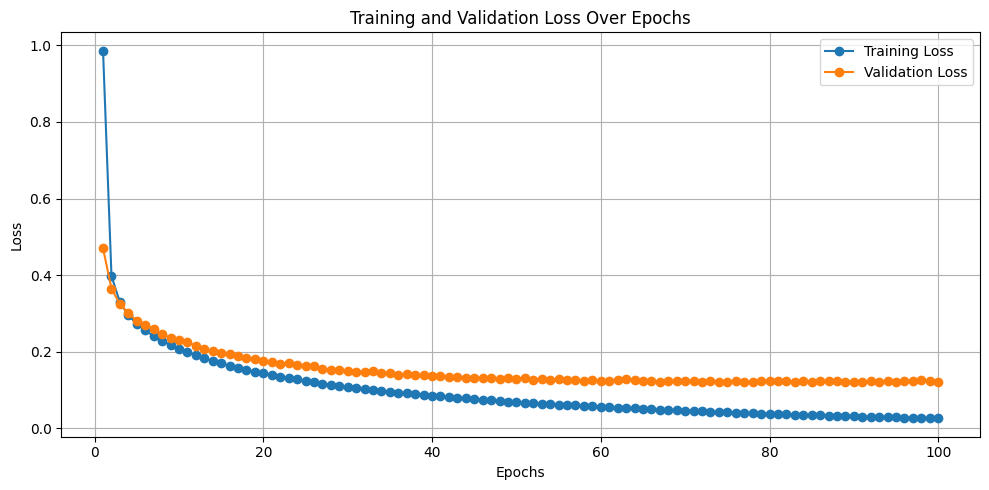

In [21]:
# val - train loss plot
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 2.3.2. Accuracy X epochs

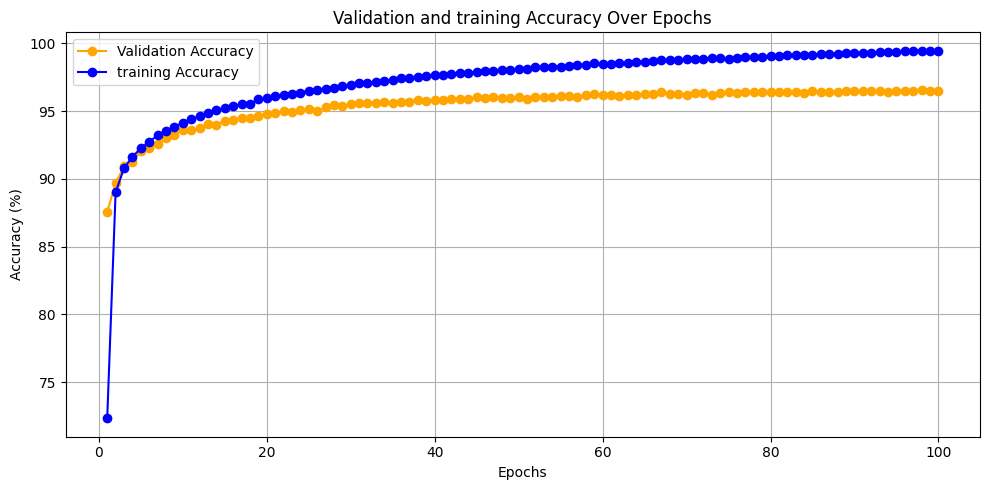

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', color='orange')
plt.plot(epochs, train_acc, 'o-', label='training Accuracy', color='blue')
plt.title('Validation and training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 2.3.3. Learning curve with error bars

2.3.3.1. Calculating the mean and standard deviation for each epoch

In [30]:
#change the lists to numpy lists
train_loss_np = np.array(all_train_loss)
train_acc_np = np.array(all_train_acc)
val_loss_np = np.array(all_val_loss)
val_acc_np = np.array(all_val_acc)

#calculate mean and std foe both val and train losses and accuracies
mean_train_loss = np.mean(train_loss_np, axis=0)
std_train_loss = np.std(train_loss_np, axis=0)

mean_val_loss = np.mean(val_loss_np, axis=0)
std_val_loss = np.std(val_loss_np, axis=0)

mean_train_acc = np.mean(train_acc_np, axis=0)
std_train_acc = np.std(train_acc_np, axis=0)

mean_val_acc = np.mean(val_acc_np, axis=0)
std_val_acc = np.std(val_acc_np, axis=0)

2.3.3.2. Plots

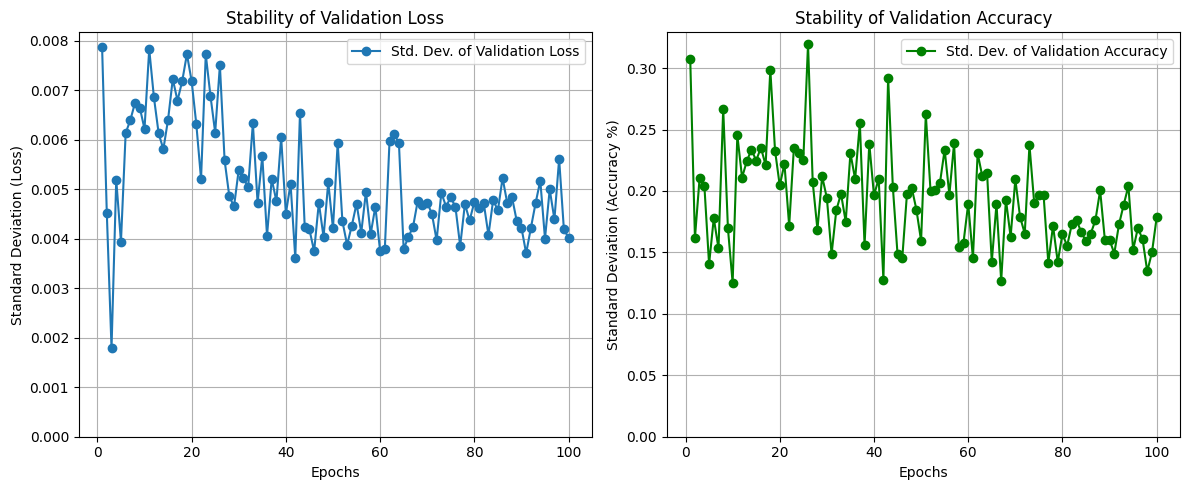

In [33]:
epochs = range(1, len(std_val_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, std_val_loss, 'o-', label='Std. Dev. of Validation Loss')
plt.title('Stability of Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation (Loss)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 

plt.subplot(1, 2, 2)
plt.plot(epochs, std_val_acc, 'o-', label='Std. Dev. of Validation Accuracy', color='green')
plt.title('Stability of Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation (Accuracy %)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 

plt.tight_layout()
plt.show()

# 3. Hyper parameters tuning.
### 3.1. Learning rate tuning.

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
max_val_acc = []

for lr in learning_rates:
    print(f"---learning rate = {lr}---\n\n")
    _ , _, _,val_accuracy = training_infrastructure(2, 64, lr, 64, 100)
    max_val_acc.append(max(val_accuracy))


---learning rate = 0.001---


Using cpu
Epoch: 1 / 100 | avg train loss: 2.2286 | train accuracy : 20.87|avg validation loss: 2.0073 | validation accuracy: 40.58 
Epoch: 2 / 100 | avg train loss: 1.7602 | train accuracy : 54.20|avg validation loss: 1.5317 | validation accuracy: 62.83 
Epoch: 3 / 100 | avg train loss: 1.3351 | train accuracy : 68.00|avg validation loss: 1.1727 | validation accuracy: 71.36 
Epoch: 4 / 100 | avg train loss: 1.0392 | train accuracy : 74.74|avg validation loss: 0.9351 | validation accuracy: 77.15 
Epoch: 5 / 100 | avg train loss: 0.8475 | train accuracy : 79.30|avg validation loss: 0.7829 | validation accuracy: 80.76 
Epoch: 6 / 100 | avg train loss: 0.7233 | train accuracy : 81.98|avg validation loss: 0.6839 | validation accuracy: 82.89 
Epoch: 7 / 100 | avg train loss: 0.6414 | train accuracy : 83.78|avg validation loss: 0.6156 | validation accuracy: 84.39 
Epoch: 8 / 100 | avg train loss: 0.5829 | train accuracy : 85.04|avg validation loss: 0.5661 | vali

In [39]:
optimal_lr = learning_rates[np.argmax(max_val_acc)]

print(f"Optimal Learning rate = {optimal_lr}\n")
max_val_acc


Optimal Learning rate = 0.1



[93.75, 96.86428571428571, 97.36428571428571, 94.55714285714286]

### 3.2. Architecture tuning.

#### 3.2.1. Number of layers tuning.

In [ ]:
number_of_layers = [2, 3, 4 , 5]
max_val_acc = []

for nol in number_of_layers:
    print(f"---Number of layers = {nol}---\n\n")
    _ , _, _,val_accuracy = training_infrastructure(nol, 64, optimal_lr, 64, 100)
    max_val_acc.append(max(val_accuracy))

---Number of layers = 2---


Using cpu
Epoch: 1 / 100 | avg train loss: 0.3739 | train accuracy : 88.77|avg validation loss: 0.2500 | validation accuracy: 92.79 
Epoch: 2 / 100 | avg train loss: 0.1798 | train accuracy : 94.75|avg validation loss: 0.2074 | validation accuracy: 93.54 
Epoch: 3 / 100 | avg train loss: 0.1355 | train accuracy : 95.95|avg validation loss: 0.2623 | validation accuracy: 91.76 
Epoch: 4 / 100 | avg train loss: 0.1094 | train accuracy : 96.67|avg validation loss: 0.1317 | validation accuracy: 95.96 
Epoch: 5 / 100 | avg train loss: 0.0924 | train accuracy : 97.21|avg validation loss: 0.1180 | validation accuracy: 96.49 
Epoch: 6 / 100 | avg train loss: 0.0796 | train accuracy : 97.61|avg validation loss: 0.1843 | validation accuracy: 94.49 
Epoch: 7 / 100 | avg train loss: 0.0697 | train accuracy : 97.93|avg validation loss: 0.1101 | validation accuracy: 96.72 
Epoch: 8 / 100 | avg train loss: 0.0596 | train accuracy : 98.20|avg validation loss: 0.1074 | valid

In [41]:
optimal_NOL = number_of_layers[np.argmax(max_val_acc)]

print(f"Optimal number of layers = {optimal_NOL}\n")
max_val_acc

Optimal number of layers = 4



[97.24285714285715, 97.55, 97.61428571428571, 97.52857142857142]

#### 3.2.2. Number of neurons per layer.

In [44]:
number_of_neurons = [64, 128, 256, 512]
max_val_acc = []


for non in number_of_neurons:
    print(f"---number of neurons = {non}---\n\n")
    _ , _, _,val_accuracy = training_infrastructure(optimal_NOL, non, optimal_lr, 64, 100)
    max_val_acc.append(max(val_accuracy))

---number of neurons = 64---


Using cpu
Epoch: 1 / 100 | avg train loss: 0.3946 | train accuracy : 87.65|avg validation loss: 0.3542 | validation accuracy: 89.44 
Epoch: 2 / 100 | avg train loss: 0.1618 | train accuracy : 95.04|avg validation loss: 1.5664 | validation accuracy: 68.06 
Epoch: 3 / 100 | avg train loss: 0.1270 | train accuracy : 96.06|avg validation loss: 0.1682 | validation accuracy: 94.94 
Epoch: 4 / 100 | avg train loss: 0.0979 | train accuracy : 96.90|avg validation loss: 0.1285 | validation accuracy: 96.06 
Epoch: 5 / 100 | avg train loss: 0.0787 | train accuracy : 97.49|avg validation loss: 0.1268 | validation accuracy: 96.12 
Epoch: 6 / 100 | avg train loss: 0.0672 | train accuracy : 97.90|avg validation loss: 0.1258 | validation accuracy: 96.17 
Epoch: 7 / 100 | avg train loss: 0.0563 | train accuracy : 98.12|avg validation loss: 0.1113 | validation accuracy: 96.75 
Epoch: 8 / 100 | avg train loss: 0.0514 | train accuracy : 98.35|avg validation loss: 1.0381 | val

In [45]:
optimal_NON = number_of_neurons[np.argmax(max_val_acc)]

print(f"Optimal number of neurons = {optimal_NON}\n")
max_val_acc

Optimal number of neurons = 512



[97.62857142857143, 97.67142857142858, 97.94285714285714, 97.99285714285715]

### 3.3. Batch size tuning.

In [47]:
batch_sizes = [16, 32, 64, 128]
max_val_acc = []

for bs in batch_sizes:
    print(f"---Batch size = {bs}---\n\n")
    _ , _, _,val_accuracy = training_infrastructure(optimal_NOL, optimal_NON, optimal_lr, bs, 100)
    max_val_acc.append(max(val_accuracy))

---Batch size = 16---


Using cpu
Epoch: 1 / 100 | avg train loss: 0.2540 | train accuracy : 92.08|avg validation loss: 0.1412 | validation accuracy: 95.61 
Epoch: 2 / 100 | avg train loss: 0.1034 | train accuracy : 96.85|avg validation loss: 0.1372 | validation accuracy: 95.96 
Epoch: 3 / 100 | avg train loss: 0.0680 | train accuracy : 97.85|avg validation loss: 0.0988 | validation accuracy: 96.99 
Epoch: 4 / 100 | avg train loss: 0.0476 | train accuracy : 98.47|avg validation loss: 0.0956 | validation accuracy: 97.32 
Epoch: 5 / 100 | avg train loss: 0.0353 | train accuracy : 98.86|avg validation loss: 0.1163 | validation accuracy: 96.89 
Epoch: 6 / 100 | avg train loss: 0.0265 | train accuracy : 99.13|avg validation loss: 0.1070 | validation accuracy: 97.32 
Epoch: 7 / 100 | avg train loss: 0.0263 | train accuracy : 99.18|avg validation loss: 0.1006 | validation accuracy: 97.48 
Epoch: 8 / 100 | avg train loss: 0.0209 | train accuracy : 99.34|avg validation loss: 0.1139 | validation

In [49]:
optimal_BS = batch_sizes[np.argmax(max_val_acc)]

print(f"Optimal batch size = {optimal_BS}\n")
max_val_acc

Optimal batch size = 16



[98.30714285714286, 98.10714285714286, 97.99285714285715, 97.80714285714286]

# 4. Optimal model evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for gpu acceleration
print(f"Using {device}") #check if gpu acceleration is working

INPUT_SIZE = 784
OUTPUT_SIZE = 10 

BATCH_SIZE = optimal_BS
NUMBER_HIDDEN_LAYERS = optimal_NOL
HIDDEN_SIZE = optimal_NON
LEARNING_RATE = optimal_lr
NUM_EPOCHS = 100

training_losses = []
training_accurices = []
validation_losses = []
validation_accurices = []

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = FeedForwardNN(INPUT_SIZE, NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

num_total_steps = len(train_loader)

for epoch in range(NUM_EPOCHS):

    # training loop
    model.train()
    current_train_loss = 0
    total = 0
    correct = 0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        #forward
        outputs = model(image)
        loss = loss_function(outputs, label)
        current_train_loss += loss.item()

        #bacward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    average_train_loss = current_train_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    training_losses.append(average_train_loss)
    training_accurices.append(train_accuracy)

    #validation loop
    model.eval()
    current_val_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            image = image.to(device)
            label = label.to(device)

            #forward
            outputs = model(image)
            loss = loss_function(outputs, label)
            current_val_loss += loss.item()

            #calc accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    #calculate average validation loss and accuracy
    average_val_loss = current_val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total

    validation_losses.append(average_val_loss)
    validation_accurices.append(validation_accuracy)
    print(f"Epoch: {epoch+1} / {NUM_EPOCHS} | avg train loss: {average_train_loss:.4f} | train accuracy : {train_accuracy:.2f}|avg test loss: {average_val_loss:.4f} | test accuracy: {validation_accuracy:.2f} ")


Using cpu
Epoch: 1 / 100 | avg train loss: 0.2509 | train accuracy : 92.13|avg test loss: 0.1124 | test accuracy: 96.54 
Epoch: 2 / 100 | avg train loss: 0.1024 | train accuracy : 96.77|avg test loss: 0.1233 | test accuracy: 96.45 
Epoch: 3 / 100 | avg train loss: 0.0694 | train accuracy : 97.83|avg test loss: 0.1079 | test accuracy: 96.82 
Epoch: 4 / 100 | avg train loss: 0.0462 | train accuracy : 98.44|avg test loss: 0.0837 | test accuracy: 97.68 
Epoch: 5 / 100 | avg train loss: 0.0407 | train accuracy : 98.64|avg test loss: 0.0915 | test accuracy: 97.36 
Epoch: 6 / 100 | avg train loss: 0.0270 | train accuracy : 99.10|avg test loss: 0.1068 | test accuracy: 97.11 
Epoch: 7 / 100 | avg train loss: 0.0202 | train accuracy : 99.37|avg test loss: 0.0918 | test accuracy: 97.47 
Epoch: 8 / 100 | avg train loss: 0.0193 | train accuracy : 99.38|avg test loss: 0.1066 | test accuracy: 97.51 
Epoch: 9 / 100 | avg train loss: 0.0136 | train accuracy : 99.55|avg test loss: 0.1266 | test accuracy

# 5. Convolutional Neural Network model

## 5.1. Model Architecture

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input: An image of size 28x28 pixels

        # First layer: Convolutional layer with 1 input channel, 16 different filters, 3x3 kernel size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # Size stays the same because padding=1

        # Second Layer: Max Pooling layer with 2x2 kernel size and compress it to half the size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Size becomes 14x14 after pooling

        # Third Layer: Convolutional layer with 16 input channels, 32 different filters, 3x3 kernel size
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Internally, we pool again to reduce size to 7x7

        # At the end of the third layer, we have 32 outputs * 7 * 7

        # Fully connected layers
        # Image will be flattened to 128 nodes
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 10)          # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolutional layer and ReLU activation
        x = self.pool1(x)          # Pooling layer
        x = F.relu(self.conv2(x))  # Second convolutional layer and ReLU activation
        x = self.pool1(x)          # Pooling layer again

        x = x.view(-1, 32 * 7 * 7) # Flatten the tensor for the fully connected layers

        x = F.relu(self.fc1(x))    # First fully connected layer and ReLU activation
        x = self.fc2(x)            # Second fully connected layer (output layer)

        return x

## 5.2. CNN Training

In [14]:
LEARNING_RATE = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for CNN training")

cnn_model = CNN().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

cnn_train_losses = []
cnn_train_accs = []
cnn_val_losses = []
cnn_val_accs = []

for epoch in range(NUM_EPOCHS):
    
    cnn_model.train() # Set to training mode
    current_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Using the same train_NN_loader from cell 10
    for images, labels in train_NN_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        
        loss = loss_function(outputs, labels)
        current_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation loop
    cnn_model.eval() # Set to evaluation mode
    current_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_NN_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = cnn_model(images)
            
            loss = loss_function(outputs, labels)
            current_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Plotting and logging
    avg_train_loss = current_train_loss / len(train_NN_loader)
    avg_val_loss = current_val_loss / len(val_NN_loader)
    
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    cnn_train_losses.append(avg_train_loss)
    cnn_val_losses.append(avg_val_loss)
    cnn_train_accs.append(train_accuracy)
    cnn_val_accs.append(val_accuracy)
    
    print(f"CNN Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Using cuda for CNN training
CNN Epoch: 1/40 | Train Loss: 1.1954 | Train Acc: 66.88% | Val Loss: 0.6960 | Val Acc: 75.48%
CNN Epoch: 2/40 | Train Loss: 0.3582 | Train Acc: 88.83% | Val Loss: 0.3128 | Val Acc: 90.06%
CNN Epoch: 3/40 | Train Loss: 0.2634 | Train Acc: 91.91% | Val Loss: 0.2356 | Val Acc: 92.63%
CNN Epoch: 4/40 | Train Loss: 0.2048 | Train Acc: 93.66% | Val Loss: 0.2130 | Val Acc: 93.49%
CNN Epoch: 5/40 | Train Loss: 0.1681 | Train Acc: 94.75% | Val Loss: 0.1887 | Val Acc: 94.19%
CNN Epoch: 6/40 | Train Loss: 0.1430 | Train Acc: 95.65% | Val Loss: 0.1370 | Val Acc: 95.81%
CNN Epoch: 7/40 | Train Loss: 0.1242 | Train Acc: 96.20% | Val Loss: 0.1382 | Val Acc: 95.73%
CNN Epoch: 8/40 | Train Loss: 0.1093 | Train Acc: 96.65% | Val Loss: 0.1403 | Val Acc: 95.59%
CNN Epoch: 9/40 | Train Loss: 0.0983 | Train Acc: 96.97% | Val Loss: 0.1391 | Val Acc: 95.54%
CNN Epoch: 10/40 | Train Loss: 0.0900 | Train Acc: 97.18% | Val Loss: 0.2908 | Val Acc: 91.00%
CNN Epoch: 11/40 | Train Loss: 

## 5.3 Plotting

In [ ]:
# Part D1: CNN vs. FFN Comparison Plots

# Get the FFN's mean performance from cell 30
ffn_val_loss_mean = mean_val_loss[:NUM_EPOCHS]
ffn_val_acc_mean = mean_val_acc[:NUM_EPOCHS]

epochs_cnn = range(1, len(cnn_val_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, cnn_val_losses, 'o-', label='CNN Validation Loss')
plt.plot(epochs_cnn, ffn_val_loss_mean, 's--', label='FFN Validation Loss (Mean)')
plt.title('CNN vs. FFN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, cnn_val_accs, 'o-', label='CNN Validation Accuracy')
plt.plot(epochs_cnn, ffn_val_acc_mean, 's--', label='FFN Validation Accuracy (Mean)')
plt.title('CNN vs. FFN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis of the benefit of spatial feature learning

Spatial feature learning in CNNs allow the model to capture local patterns in images, such as edges, textures, and shapes. It prevents overfitting since the filter passes over the image, learning only the important features. After that, the pooling layers reduce the spatial dimensions, which doesn't just decrease computational load but also makes the model only retain the important features which makes it more general.

# 6. Dropout Analysis and Batch Normalization

### 6.1. Define FFN with Dropout and BatchNorm layers

This class inherits from the FeedForwardNN class defined earlier and adds dropout layers after each hidden layer.

In [ ]:
class FeedForwardNN_Dropout(FeedForwardNN):
    def __init__(self, input_size, number_hidden_layers, hidden_size, output_size, dropout_rate=0.5):
        super().__init__(input_size, number_hidden_layers, hidden_size, output_size)
        
        self.dropouts = nn.ModuleList()
        for _ in range(number_hidden_layers): # One dropout for each hidden layer
            self.dropouts.append(nn.Dropout(dropout_rate))

    # Override the forward method
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten as it is done in the parent class
        
        # Loop through hidden layers and their corresponding dropouts
        for i in range(len(self.layers) - 1): # All layers except the final output layer
            
            # Pass through Linear layer, then ReLU
            x = self.layers[i](x)
            x = F.relu(x)
            
            # Apply dropout
            # This should only be active during model.train()
            x = self.dropouts[i](x) 
            
        # Apply output layer (no dropout)
        x = self.layers[-1](x)
        return x